# 1- Librerias y config

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import seaborn as sns
import re

pd.set_option('display.max_columns', None)

sys.path.append('./../')
import config
from utils import tools
from data_analysis import analysis_utils

In [2]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman'] 
mpl.rcParams['text.usetex'] = False

# 2. Processor

In [3]:
class DataProcessor:
    def __init__(self):
        self.dos_csv_path = config.DOS_CSV_PATH
        self.supercon_csv_path = config.SUPERCON_CSV_PATH

    def read_supercon_database(self):
        self.supercon_data = pd.read_csv(self.supercon_csv_path, skiprows=1)
        self.supercon_data.columns = ['chemical_formula', 'critical_temperature_k', 'ICSD', 'synth_doped']
        self.supercon_data['ICSD'] = self.supercon_data['ICSD'].str.replace('ICSD-', '')

    def read_materials_csv(self):
        self.materials_data = pd.read_csv(self.dos_csv_path)
        self.ICSD_preprocessor()
        self.identify_superconductors()

    def ICSD_preprocessor(self):
        self.materials_data['ICSD'] = pd.to_numeric(self.materials_data['ICSD'], errors='coerce').astype('Int64')
        num_nulos = self.materials_data['ICSD'].isnull().sum()
        len_df_pre = len(self.materials_data)
        print(f"{num_nulos} rows ({num_nulos/len_df_pre*100:.4f} %) where dropped because of null on ICSD.")
        self.materials_data.dropna(subset=['ICSD'], inplace=True)

    def identify_superconductors(self):
        ICSD_supercon = self.supercon_data.ICSD.unique().astype(int).tolist()
        self.materials_data.insert(5, 'is_superconductor', self.materials_data.ICSD.isin(ICSD_supercon))

    def processor(self):
        self.read_supercon_database()
        self.read_materials_csv()
        return self.materials_data, self.supercon_data


MaterialsProcessor = DataProcessor()
materials_data, supercon_data = MaterialsProcessor.processor()

C:\Users\olaya\AppData\Local\Temp\ipykernel_15588\2883198947.py:12: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  self.materials_data = pd.read_csv(self.dos_csv_path)


1 rows (0.0017 %) where dropped because of null on ICSD.


# 3. EDA

2024-06-11 20:55:25: · MODULE: StatsReporter...


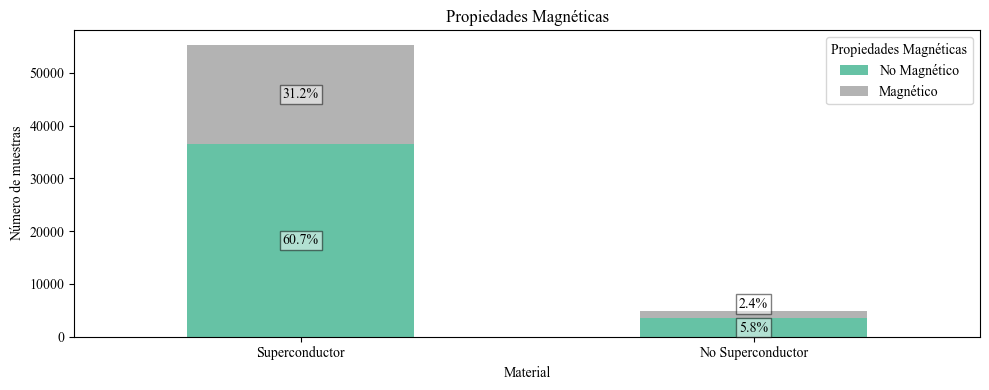

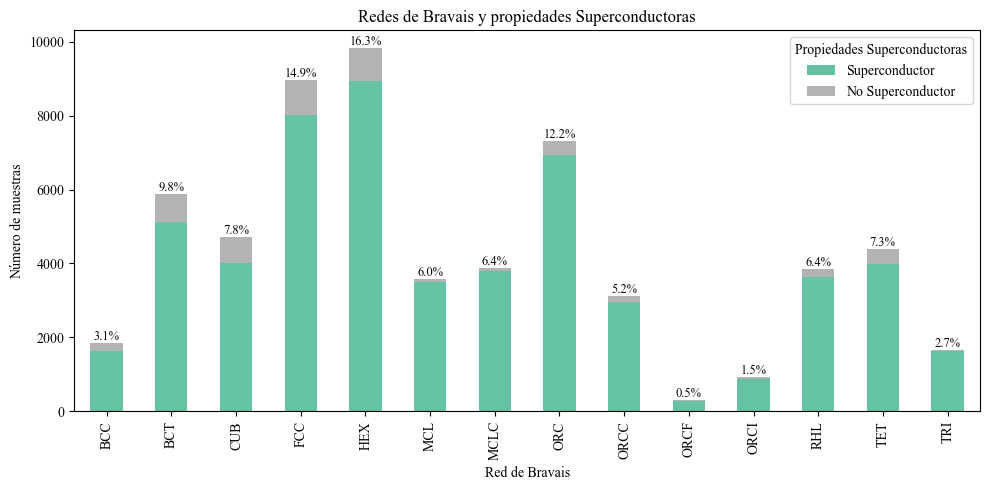

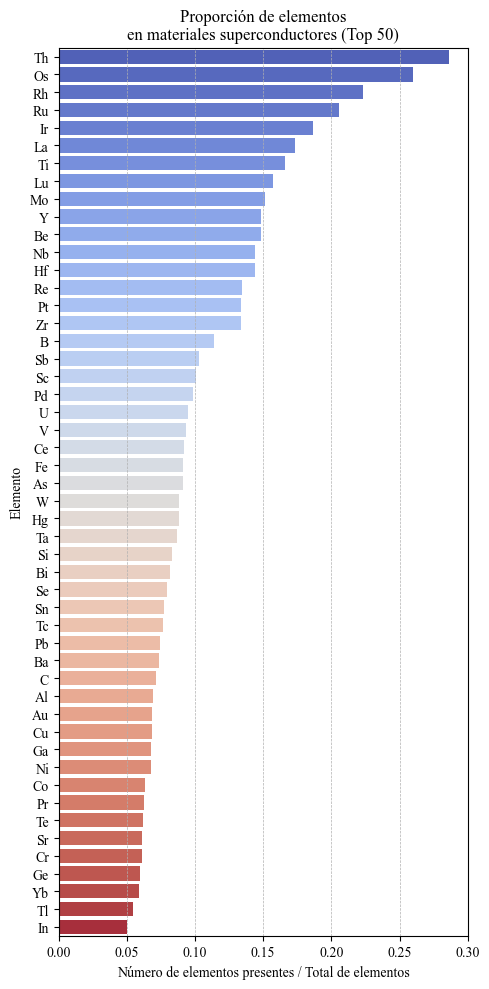

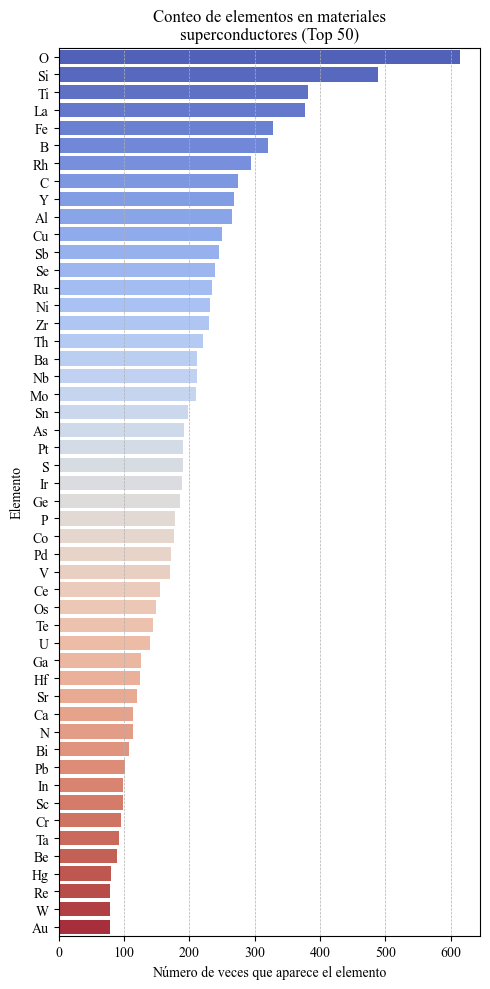

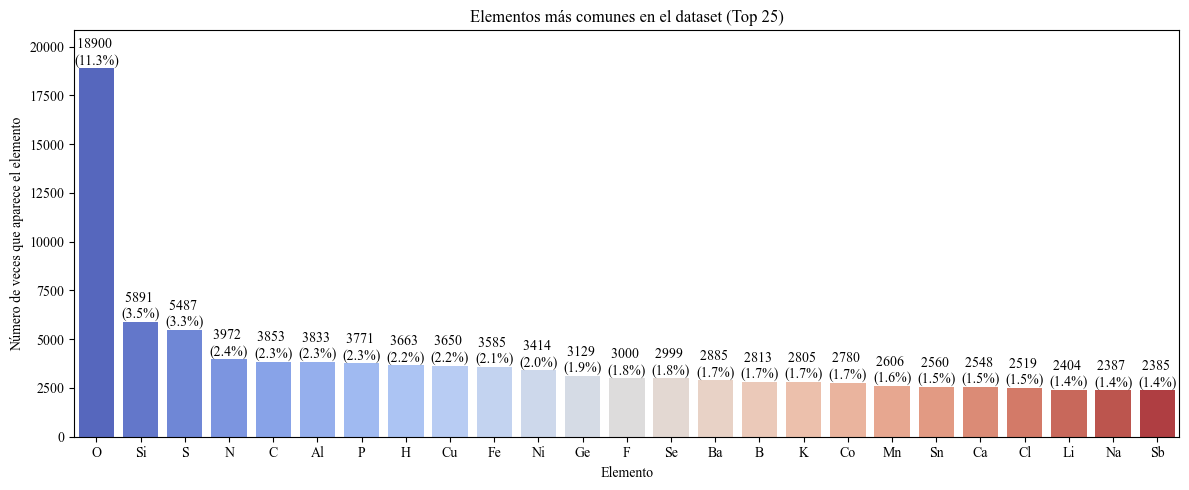

In [4]:
class StatsReporter:
    def __init__(self, materials_data, run_results_path):
        self.materials_data = materials_data
        self.run_results_path = run_results_path
        tools.log_main('· MODULE: StatsReporter...', save_path=self.run_results_path)

    def _calculate_stats(self, column_name):
        """Calculates and returns statistics for a given column."""
        value_counts = self.materials_data[column_name].value_counts()
        total_count = len(self.materials_data[column_name])
        true_count = value_counts.get(True, 0)
        true_percentage = (true_count / total_count) * 100
        return true_percentage, total_count, true_count

    def superconductors_stats(self, report_file):
        """Calculates and writes superconductor statistics to a report file."""
        true_percentage, total_count, true_count = self._calculate_stats('is_superconductor')
        tools.write_to_report(report_file, f"Percentage of superconductors: {true_percentage:.2f}%\n")
        tools.write_to_report(report_file, f'Total materials: {total_count}\n')
        tools.write_to_report(report_file, f'Superconducting materials: {true_count}\n')

    def magnetic_stats(self, report_file):
        """Calculates and writes magnetic statistics to a report file."""
        true_percentage, total_count, true_count = self._calculate_stats('is_magnetic')
        tools.write_to_report(report_file, f"Percentage of magnetic: {true_percentage:.2f}%\n")
        tools.write_to_report(report_file, f'Total materials: {total_count}\n')
        tools.write_to_report(report_file, f'Magnetic materials: {true_count}\n')

    def element_stats(self, report_file):
        """Calculates and writes element statistics to the report."""
        df = self.materials_data[['material_name', 'is_superconductor']].copy()
        df = analysis_utils.extract_elements_from_dataframe(df)
        element_df = analysis_utils.create_element_dataframe(df)

        total_elements = len(element_df['element'].unique())

        superconductor_elements = element_df[element_df['is_superconductor'] == True]['element'].unique()
        num_superconductor_elements = len(superconductor_elements)
        percentage_superconductor_elements = (num_superconductor_elements / total_elements) * 100

        nonsuperconductor_elements = element_df[element_df['is_superconductor'] == False]['element'].unique()
        num_nonsuperconductor_elements = len(nonsuperconductor_elements)
        percentage_nonsuperconductor_elements = (num_nonsuperconductor_elements / total_elements) * 100

        tools.write_to_report(report_file, f"\n--- Estadísticas de Elementos ---\n")
        tools.write_to_report(report_file, f"Número total de elementos únicos: {total_elements}\n")
        tools.write_to_report(report_file, f"Número de elementos en superconductores: {num_superconductor_elements} ({percentage_superconductor_elements:.2f}%)\n")
        tools.write_to_report(report_file, f"Número de elementos en NO superconductores: {num_nonsuperconductor_elements} ({percentage_nonsuperconductor_elements:.2f}%)\n")

    def stats_report(self):
        """Writes the complete statistics report to a file."""
        report_file = os.path.join(self.run_results_path, 'stats_report.txt')
        if not os.path.exists(report_file):
            tools.write_to_report(report_file, f'···················· STATISTICS ····················\n')
        self.superconductors_stats(report_file)
        tools.write_to_report(report_file, f'····················································\n')
        self.magnetic_stats(report_file)
        tools.write_to_report(report_file, f'····················································\n')
        self.element_stats(report_file)

class Plotter:
    def __init__(self, materials_data, run_results_path):
        self.materials_data = materials_data
        self.run_results_path = run_results_path

    def magnetic_properties_plot(self):
        grouped_data = self.materials_data.groupby(['is_superconductor', 'is_magnetic']).size()
        ax = grouped_data.unstack().plot(kind='bar', stacked=True, colormap='Set2', figsize=(10,4))
        for p in ax.patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy() 

            percentage = height / grouped_data.sum() * 100
            if height < 0.05 * grouped_data.sum(): 
                ax.text(x + width/2, y + height + 0.01, f'{percentage:.1f}%',  
                        ha='center', va='bottom', fontsize=10, color='black',
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2})
            else:
                ax.text(x + width/2, y + height/2, f'{percentage:.1f}%', 
                        ha='center', va='center', fontsize=10, color='black',
                        bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2})

        plt.title('Propiedades Magnéticas')
        plt.xlabel('Material')
        plt.ylabel('Número de muestras')
        plt.xticks([0, 1], ['Superconductor', 'No Superconductor'], rotation=0)
        plt.legend(title='Propiedades Magnéticas', labels=['No Magnético', 'Magnético'])
        plt.tight_layout()
        tools.save_plot(self.run_results_path, 'magnetic_properties')
        # plt.show()

    def supercon_properties_by_bravais_plot(self):
        grouped_data = self.materials_data.groupby(['bravais_lattice', 'is_superconductor']).size()
        unstacked_data = grouped_data.unstack(fill_value=0)

        ax = unstacked_data.plot(kind='bar', stacked=True, colormap='Set2', figsize=(10, 5))
        total_samples = len(self.materials_data)

        for i, patch in enumerate(ax.patches[:len(unstacked_data)]): 
            height = patch.get_height() + ax.patches[i + len(unstacked_data)].get_height() 
            percentage = 100 * height / total_samples
            ax.annotate(f'{percentage:.1f}%', 
                        xy=(patch.get_x() + patch.get_width() / 2, height),  
                        ha='center', va='bottom', fontsize=9, color='black')

        plt.title('Redes de Bravais y propiedades Superconductoras')
        plt.xlabel('Red de Bravais')
        plt.ylabel('Número de muestras')
        plt.legend(title='Propiedades Superconductoras', labels=['Superconductor', 'No Superconductor'])
        plt.tight_layout()
        tools.save_plot(self.run_results_path, 'superconducting_properties_by_bravais_lattice')
        # plt.show()
    
    def _calculate_element_statistics(self, element_df):
        """Calculates element statistics."""
        superconductors_count = element_df[element_df['is_superconductor'] == True]['element'].value_counts()
        total_count = element_df['element'].value_counts()
        proportion_superconductors = (superconductors_count / total_count).fillna(0)
        return superconductors_count, proportion_superconductors

    def _plot_element_proportion(self, proportion_data, title, filename):
        """Plots the proportion of elements."""
        plt.figure(figsize=(5, 10))
        ax = sns.barplot(x=proportion_data.values, y=proportion_data.index, palette='coolwarm')
        plt.xlabel('Número de elementos presentes / Total de elementos')
        plt.ylabel('Elemento')
        plt.title(title)
        ax.xaxis.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        tools.save_plot(self.run_results_path, filename)
        # plt.show()

    def _plot_element_counts(self, counts_data, title, filename):
        """Plots the element counts."""
        plt.figure(figsize=(5, 10))
        ax = sns.barplot(x=counts_data.values, y=counts_data.index, palette='coolwarm')
        plt.xlabel('Número de veces que aparece el elemento')
        plt.ylabel('Elemento')
        plt.title(title)
        ax.xaxis.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        tools.save_plot(self.run_results_path, filename)
        # plt.show()

    def _plot_top_elements_overall(self, element_df, top_n=25):
        """Plots the most common elements overall."""
        total_element_counts = element_df['element'].value_counts()
        top_elements = total_element_counts.nlargest(top_n)

        plt.figure(figsize=(12, 5))
        ax = sns.barplot(x=top_elements.index, y=top_elements.values, palette='coolwarm')
        plt.ylabel('Número de veces que aparece el elemento')
        plt.xlabel('Elemento')
        plt.title(f'Elementos más comunes en el dataset (Top {top_n})')

        total_elementos = len(element_df)
        y_max = ax.get_ylim()[1]
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 200, 
                    f'{int(height)} \n({(height/total_elementos)*100:.1f}%)',
                    ha="center")
        plt.ylim(0, y_max*1.05)

        plt.tight_layout()
        tools.save_plot(self.run_results_path, 'element_analysis_3')
        # plt.show()

    def element_analysis_plots(self):
        """Generates and saves element analysis plots."""
        df = self.materials_data[['bravais_lattice', 'material_name', 
                                  'ICSD', 'fermi_energy', 'is_magnetic', 
                                  'is_superconductor']].copy()
        df = analysis_utils.extract_elements_from_dataframe(df)
        element_df = analysis_utils.create_element_dataframe(df)
        superconductors_count, proportion_superconductors = self._calculate_element_statistics(element_df)

        top_proportion_superconductors = proportion_superconductors.nlargest(50).sort_values(ascending=False)
        top_superconductors_counts = superconductors_count.nlargest(50).sort_values(ascending=False)

        self._plot_element_proportion(top_proportion_superconductors, 
                                      'Proporción de elementos\nen materiales superconductores (Top 50)',
                                      'element_analysis_1')
        self._plot_element_counts(top_superconductors_counts, 
                                   'Conteo de elementos en materiales\nsuperconductores (Top 50)', 
                                   'element_analysis_2')
        self._plot_top_elements_overall(element_df)

    def workflow(self):
        self.magnetic_properties_plot()
        self.supercon_properties_by_bravais_plot()
        self.element_analysis_plots()

stats_reporter = StatsReporter(materials_data, config.PATH_TEST_FIGURES)  # Assuming you have a config module
stats_reporter.stats_report()

plotter = Plotter(materials_data, config.PATH_TEST_FIGURES)
plotter.workflow()

# 4. Modelos ¿?

Añadir en el eda gráficas de medias y medianas de los elementos.

Empezar con algun modelo simple de clasificacion y seguir con modelos mas complejos.

Añadir bases de datos que permitan discenir superconductores y no 100%.

Entrenar autogluon e imprimirlo en reporte de .txt.